# Stock Forecasting with Convolution and LSTM

with Eric Wolos

The objective of this project is to compare the forecasting abilities of different deep learning networks that use LSTM (Long Short Term Memory) cells, or the novel Wavenet architecture, which uses entirely convolution.

For a baseline comparison, these models will be compared to a naive forecast with the metric of mean absolute percentage error.

## Download and Visualize Data

In [1]:
import datetime as dt
import pandas_datareader.data as pd_web
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ticker = "NVDA"
previousdays = 1800

In [3]:
# Function to return dataframe of stock data between today and previous n days, where n is daysPast.
# Note that daysPast includes weekends and holidays, even though there is no data on these days.

def getPresentStockData(ticker, daysPast):
    final_date =  dt.date.today() + dt.timedelta(-1*daysPast)
    new_data = pd_web.DataReader(ticker, 'yahoo', final_date)
    return new_data

In [4]:
data = getPresentStockData(ticker,previousdays)

In [5]:
series = data['Adj Close']

To get an accurate sense of how well models might perform, the data is broken up into training (80%), validation (10%), and testing (10%) datasets. Models are trained on training data, tuned on performance with validation data, and finally tested with testing data.

In [6]:
test_ratio = 0.1
val_ratio = 0.1
train_ratio = 1 - test_ratio - val_ratio

In [7]:
testStartTime = int(len(series)*(train_ratio + val_ratio))
trainEndTime = int(len(series)*train_ratio)

In [8]:
testDates = series.index[testStartTime:]
testValues = series[testStartTime:]

trainDates = series.index[:testStartTime]
trainValues = series[:testStartTime]

valDates = series.index[trainEndTime:(testStartTime+1)]
valValues = series[trainEndTime:(testStartTime+1)]

Let's visualize our data first to see how it looks over time.

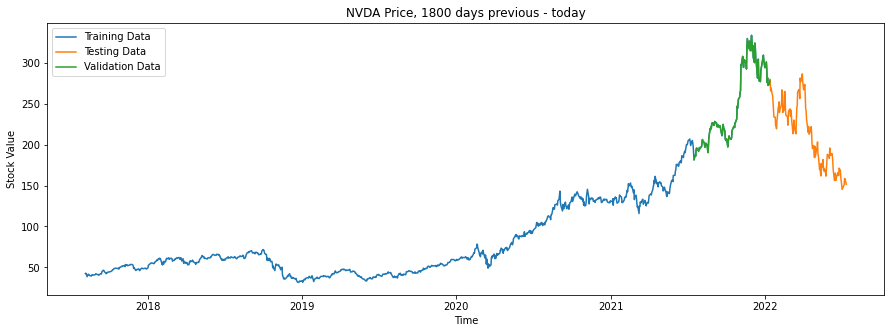

In [9]:
fig = plt.figure(figsize=(15,5))
plt.plot(trainDates,trainValues)
plt.plot(testDates,testValues)
plt.plot(valDates,valValues)
plt.legend(["Training Data","Testing Data", "Validation Data"])
plt.xlabel("Time")
plt.ylabel("Stock Value")
plt.title(f"{ticker} Price, {previousdays} days previous - today")
plt.show()

## Establishing a Baseline

Let's get a feel for how a naive model might predict the market by looking at its performance with the metric of mean absolute percentage error.

This naive forecast will form a rough baseline so that we have an effective comparative tool for market projections.

In [10]:
# The naive forecast rows are the date the forecast comes from and the price that of that date. 
# Its index corresponds to the day forecasted in testValues
# For instance, naiveForecast[0] is the forecasted price for the first day of testValues.

naiveForecast = series[-(len(testValues)+1):].drop(testValues.index[-1])
nMAPE = tf.keras.metrics.mean_absolute_percentage_error(testValues, naiveForecast).numpy()
print(f"The Mean Absolute Percent Error for the Niave Forecast is {nMAPE}%")

The Mean Absolute Percent Error for the Niave Forecast is 3.591197531739089%


In [11]:
valueRange = max(series) - min(series)

## LSTM Neural Network

In [12]:
def windowDS(series, batchSize, windowSize):
    series = tf.expand_dims(series, axis = -1)
    slices = tf.data.Dataset.from_tensor_slices(series)
    windowSlices = slices.window(windowSize+1, shift = 1, drop_remainder=True)
    tensors = windowSlices.flat_map(lambda x: x.batch(windowSize+1))
    tensors = tensors.map(lambda x: (x[:-1], x[-1:]))
    tensors = tensors.shuffle(buffer_size = len(series) + 1) 
    batches = tensors.batch(batchSize).prefetch(1)
    return batches

In [13]:
windowSize = 1
batchSize = 32

train = windowDS(trainValues, batchSize, windowSize)
val = windowDS(valValues, batchSize, windowSize)

In [14]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, 
                           kernel_size=5,
                           strides=1, 
                           padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 15 * valueRange)
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 32)          6272      
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          8320      
                                                                 
 dense (Dense)               (None, None, 1)           33        
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 14,721
Trainable params: 14,721
Non-trainable params: 0
_________________________________________________________________


In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-9, momentum=0.9)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.Huber(),
              metrics = [tf.keras.metrics.MeanAbsolutePercentageError()]
)


In [17]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("TScheckpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50,min_delta = 0.01)

class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()
resetStates = ResetStatesCallback()

In [18]:
LSTMhistory = model.fit(train,
          epochs=1000,
          validation_data=val,
          callbacks = [model_checkpoint,early_stopping, resetStates])

Epoch 1/1000
35/35 [==============================] - 4s 33ms/step - loss: 191.2963 - mean_absolute_percentage_error: 313.7147 - val_loss: 191.6481 - val_mean_absolute_percentage_error: 77.0034
Epoch 2/1000
35/35 [==============================] - 0s 4ms/step - loss: 147.5168 - mean_absolute_percentage_error: 248.9413 - val_loss: 151.2981 - val_mean_absolute_percentage_error: 59.9768
Epoch 3/1000
35/35 [==============================] - 0s 4ms/step - loss: 103.0633 - mean_absolute_percentage_error: 181.9193 - val_loss: 111.5330 - val_mean_absolute_percentage_error: 43.2293
Epoch 4/1000
35/35 [==============================] - 0s 4ms/step - loss: 68.7237 - mean_absolute_percentage_error: 127.2781 - val_loss: 84.2200 - val_mean_absolute_percentage_error: 31.7425
Epoch 5/1000
35/35 [==============================] - 0s 4ms/step - loss: 55.6003 - mean_absolute_percentage_error: 99.2619 - val_loss: 67.0799 - val_mean_absolute_percentage_error: 24.5452
Epoch 6/1000
35/35 [===================

Epoch 44/1000
35/35 [==============================] - 0s 3ms/step - loss: 25.6565 - mean_absolute_percentage_error: 35.7599 - val_loss: 78.6947 - val_mean_absolute_percentage_error: 30.1629
Epoch 45/1000
35/35 [==============================] - 0s 3ms/step - loss: 25.2458 - mean_absolute_percentage_error: 35.0930 - val_loss: 79.4479 - val_mean_absolute_percentage_error: 30.4977
Epoch 46/1000
35/35 [==============================] - 0s 3ms/step - loss: 24.8418 - mean_absolute_percentage_error: 34.2993 - val_loss: 79.4424 - val_mean_absolute_percentage_error: 30.5140
Epoch 47/1000
35/35 [==============================] - 0s 3ms/step - loss: 24.4550 - mean_absolute_percentage_error: 33.5231 - val_loss: 79.6240 - val_mean_absolute_percentage_error: 30.6086
Epoch 48/1000
35/35 [==============================] - 0s 3ms/step - loss: 24.0686 - mean_absolute_percentage_error: 32.6870 - val_loss: 79.2425 - val_mean_absolute_percentage_error: 30.4667
Epoch 49/1000
35/35 [========================

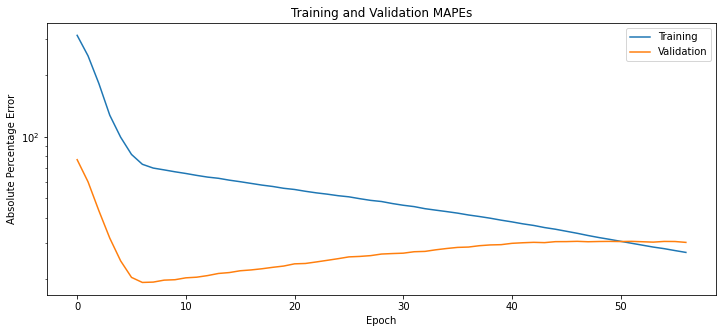

In [19]:
fig = plt.figure(figsize=(12,5))
plt.semilogy(LSTMhistory.history["mean_absolute_percentage_error"])
plt.semilogy(LSTMhistory.history["val_mean_absolute_percentage_error"])
plt.xlabel("Epoch")
plt.ylabel("Absolute Percentage Error")
plt.legend(["Training","Validation"])
plt.title('Training and Validation MAPEs')
plt.show()

In [20]:
min(LSTMhistory.history["val_mean_absolute_percentage_error"])

19.235763549804688

In [21]:
model = tf.keras.models.load_model("TScheckpoint.h5")

In [22]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

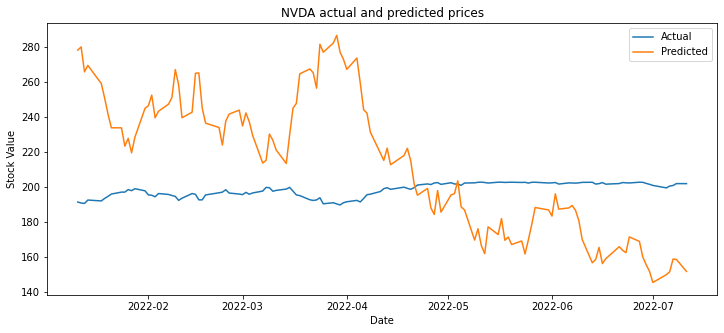

In [23]:
predictions = model_forecast(model, tf.expand_dims(series,-1), windowSize)
LSTMforecast = predictions[testStartTime - windowSize:-1, -1, 0]

fig = plt.figure(figsize=(12,5))
plt.plot(testDates,LSTMforecast)
plt.xlabel("Date")
plt.ylabel("Stock Value")
plt.plot(testDates,testValues)
plt.legend(["Actual","Predicted"])
plt.title(f'{ticker} actual and predicted prices')
plt.show()


In [24]:
LSTMMAPE = tf.keras.metrics.mean_absolute_percentage_error(testValues, LSTMforecast).numpy()
print(f"The Mean Absolute Percent Error for the LSTM is {LSTMMAPE}%")

The Mean Absolute Percent Error for the LSTM is 18.43315887451172%


## Wavenet - Fully Convolutional Forecasting

Based off of WaveNet architecture. 

For an effective visualization: https://en.wikipedia.org/wiki/WaveNet#/media/File:WaveNet_animation.gif

In [25]:
windowSize = 1
batchSize = 32

train = windowDS(trainValues, batchSize, windowSize)
val = windowDS(valValues, batchSize, windowSize)

In [26]:
# Hidden Convolutional Layers
numConvBlocks = 6

In [27]:
tf.keras.backend.clear_session()
convModel = tf.keras.models.Sequential()
convModel.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for dilationRate in [2**i for i in range(numConvBlocks)]:
    convModel.add(
      tf.keras.layers.Conv1D(filters=16,
                          kernel_size=3,
                          strides=1,
                          dilation_rate=dilationRate,
                          padding="causal",
                          activation="relu")
    )
convModel.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))

In [28]:
convModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          64        
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          784       
                                                                 
 conv1d_2 (Conv1D)           (None, None, 16)          784       
                                                                 
 conv1d_3 (Conv1D)           (None, None, 16)          784       
                                                                 
 conv1d_4 (Conv1D)           (None, None, 16)          784       
                                                                 
 conv1d_5 (Conv1D)           (None, None, 16)          784       
                                                                 
 conv1d_6 (Conv1D)           (None, None, 1)           1

In [29]:
convOptimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)
convModel.compile(optimizer=convOptimizer,
              loss=tf.keras.losses.Huber(),
              metrics = [tf.keras.metrics.MeanAbsolutePercentageError()]
)

In [30]:
convModel_checkpoint = tf.keras.callbacks.ModelCheckpoint("TSConvcheckpoint.h5", save_best_only=True)

In [31]:
convHistory = convModel.fit(train,
                            epochs=500,
                            validation_data=val,
                            callbacks = [model_checkpoint,early_stopping, resetStates])

Epoch 1/500
35/35 [==============================] - 1s 12ms/step - loss: 94.5254 - mean_absolute_percentage_error: 100.0156 - val_loss: 246.8380 - val_mean_absolute_percentage_error: 100.0155
Epoch 2/500
35/35 [==============================] - 0s 5ms/step - loss: 94.5227 - mean_absolute_percentage_error: 100.0117 - val_loss: 246.8337 - val_mean_absolute_percentage_error: 100.0138
Epoch 3/500
35/35 [==============================] - 0s 4ms/step - loss: 94.5197 - mean_absolute_percentage_error: 100.0076 - val_loss: 246.8295 - val_mean_absolute_percentage_error: 100.0120
Epoch 4/500
35/35 [==============================] - 0s 4ms/step - loss: 94.5167 - mean_absolute_percentage_error: 100.0035 - val_loss: 246.8253 - val_mean_absolute_percentage_error: 100.0103
Epoch 5/500
35/35 [==============================] - 0s 4ms/step - loss: 94.5137 - mean_absolute_percentage_error: 99.9994 - val_loss: 246.8211 - val_mean_absolute_percentage_error: 100.0086
Epoch 6/500
35/35 [=====================

Epoch 44/500
35/35 [==============================] - 0s 4ms/step - loss: 94.4016 - mean_absolute_percentage_error: 99.8430 - val_loss: 246.6642 - val_mean_absolute_percentage_error: 99.9440
Epoch 45/500
35/35 [==============================] - 0s 4ms/step - loss: 94.3988 - mean_absolute_percentage_error: 99.8391 - val_loss: 246.6602 - val_mean_absolute_percentage_error: 99.9424
Epoch 46/500
35/35 [==============================] - 0s 4ms/step - loss: 94.3960 - mean_absolute_percentage_error: 99.8352 - val_loss: 246.6562 - val_mean_absolute_percentage_error: 99.9407
Epoch 47/500
35/35 [==============================] - 0s 4ms/step - loss: 94.3931 - mean_absolute_percentage_error: 99.8313 - val_loss: 246.6521 - val_mean_absolute_percentage_error: 99.9390
Epoch 48/500
35/35 [==============================] - 0s 4ms/step - loss: 94.3903 - mean_absolute_percentage_error: 99.8273 - val_loss: 246.6480 - val_mean_absolute_percentage_error: 99.9374
Epoch 49/500
35/35 [=========================

Epoch 87/500
35/35 [==============================] - 0s 4ms/step - loss: 94.2705 - mean_absolute_percentage_error: 99.6662 - val_loss: 246.4609 - val_mean_absolute_percentage_error: 99.8606
Epoch 88/500
35/35 [==============================] - 0s 4ms/step - loss: 94.2669 - mean_absolute_percentage_error: 99.6615 - val_loss: 246.4548 - val_mean_absolute_percentage_error: 99.8581
Epoch 89/500
35/35 [==============================] - 0s 4ms/step - loss: 94.2633 - mean_absolute_percentage_error: 99.6568 - val_loss: 246.4485 - val_mean_absolute_percentage_error: 99.8555
Epoch 90/500
35/35 [==============================] - 0s 4ms/step - loss: 94.2596 - mean_absolute_percentage_error: 99.6521 - val_loss: 246.4421 - val_mean_absolute_percentage_error: 99.8529
Epoch 91/500
35/35 [==============================] - 0s 4ms/step - loss: 94.2559 - mean_absolute_percentage_error: 99.6473 - val_loss: 246.4355 - val_mean_absolute_percentage_error: 99.8502
Epoch 92/500
35/35 [=========================

Epoch 130/500
35/35 [==============================] - 0s 4ms/step - loss: 94.0413 - mean_absolute_percentage_error: 99.3882 - val_loss: 245.9910 - val_mean_absolute_percentage_error: 99.6694
Epoch 131/500
35/35 [==============================] - 0s 4ms/step - loss: 94.0329 - mean_absolute_percentage_error: 99.3785 - val_loss: 245.9721 - val_mean_absolute_percentage_error: 99.6617
Epoch 132/500
35/35 [==============================] - 0s 4ms/step - loss: 94.0243 - mean_absolute_percentage_error: 99.3688 - val_loss: 245.9527 - val_mean_absolute_percentage_error: 99.6538
Epoch 133/500
35/35 [==============================] - 0s 4ms/step - loss: 94.0155 - mean_absolute_percentage_error: 99.3587 - val_loss: 245.9327 - val_mean_absolute_percentage_error: 99.6457
Epoch 134/500
35/35 [==============================] - 0s 4ms/step - loss: 94.0065 - mean_absolute_percentage_error: 99.3482 - val_loss: 245.9116 - val_mean_absolute_percentage_error: 99.6372
Epoch 135/500
35/35 [===================

Epoch 173/500
35/35 [==============================] - 0s 4ms/step - loss: 93.1163 - mean_absolute_percentage_error: 98.3821 - val_loss: 243.6367 - val_mean_absolute_percentage_error: 98.7160
Epoch 174/500
35/35 [==============================] - 0s 4ms/step - loss: 93.0594 - mean_absolute_percentage_error: 98.3211 - val_loss: 243.4851 - val_mean_absolute_percentage_error: 98.6546
Epoch 175/500
35/35 [==============================] - 0s 4ms/step - loss: 92.9982 - mean_absolute_percentage_error: 98.2554 - val_loss: 243.3223 - val_mean_absolute_percentage_error: 98.5888
Epoch 176/500
35/35 [==============================] - 0s 4ms/step - loss: 92.9321 - mean_absolute_percentage_error: 98.1848 - val_loss: 243.1451 - val_mean_absolute_percentage_error: 98.5170
Epoch 177/500
35/35 [==============================] - 0s 4ms/step - loss: 92.8604 - mean_absolute_percentage_error: 98.1080 - val_loss: 242.9528 - val_mean_absolute_percentage_error: 98.4392
Epoch 178/500
35/35 [===================

Epoch 216/500
35/35 [==============================] - 0s 4ms/step - loss: 1.6591 - mean_absolute_percentage_error: 2.1812 - val_loss: 5.3842 - val_mean_absolute_percentage_error: 2.2470
Epoch 217/500
35/35 [==============================] - 0s 4ms/step - loss: 1.6542 - mean_absolute_percentage_error: 2.2037 - val_loss: 5.2577 - val_mean_absolute_percentage_error: 2.2001
Epoch 218/500
35/35 [==============================] - 0s 4ms/step - loss: 1.6527 - mean_absolute_percentage_error: 2.1776 - val_loss: 5.2316 - val_mean_absolute_percentage_error: 2.1884
Epoch 219/500
35/35 [==============================] - 0s 4ms/step - loss: 1.6624 - mean_absolute_percentage_error: 2.1748 - val_loss: 5.5626 - val_mean_absolute_percentage_error: 2.3262
Epoch 220/500
35/35 [==============================] - 0s 4ms/step - loss: 1.6855 - mean_absolute_percentage_error: 2.2268 - val_loss: 5.2550 - val_mean_absolute_percentage_error: 2.1940
Epoch 221/500
35/35 [==============================] - 0s 4ms/ste

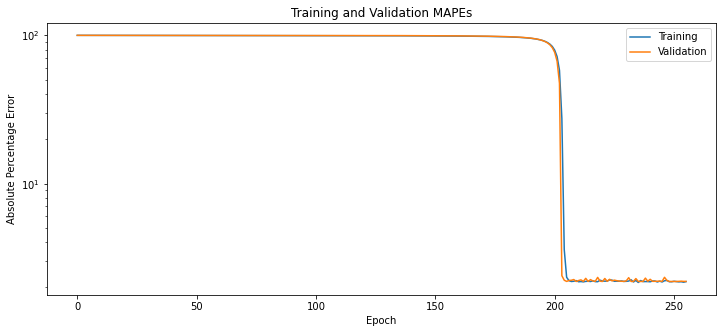

In [32]:
fig = plt.figure(figsize=(12,5))
plt.semilogy(convHistory.history["mean_absolute_percentage_error"])
plt.semilogy(convHistory.history["val_mean_absolute_percentage_error"])
plt.xlabel("Epoch")
plt.ylabel("Absolute Percentage Error")
plt.legend(["Training","Validation"])
plt.title('Training and Validation MAPEs')
plt.show()

In [33]:
min(convHistory.history["val_mean_absolute_percentage_error"])

2.1820623874664307

In [34]:
convModel = tf.keras.models.load_model("TSConvcheckpoint.h5")

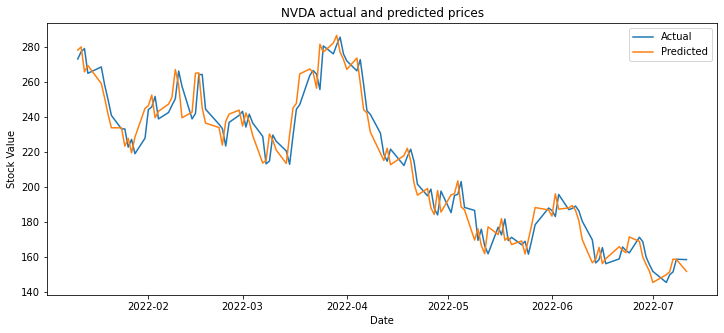

In [35]:
predictions = model_forecast(convModel, tf.expand_dims(series,-1), windowSize)
convForecast = predictions[testStartTime - windowSize:-1, -1, 0]

fig = plt.figure(figsize=(12,5))
plt.plot(testDates,convForecast)
plt.xlabel("Date")
plt.ylabel("Stock Value")
plt.plot(testDates,testValues)
plt.legend(["Actual","Predicted"])
plt.title(f'{ticker} actual and predicted prices')
plt.show()


In [36]:
convMAPE = tf.keras.metrics.mean_absolute_percentage_error(testValues, convForecast).numpy()
print(f"The Mean Absolute Percent Error for the deep CNN (Wavenet) is {convMAPE}%")

The Mean Absolute Percent Error for the deep CNN (Wavenet) is 3.565849781036377%


In [37]:
convMAPE < nMAPE

True

# Conclusion

Only the Wavenet model was able to outperform the naive prediction, and not by a marginal amount. While this might seem discouraging, it could be an indication that the markets are efficient and that trading patterns are hard to detect. In general, naive forecasts may tend to be deceivingly difficult to beat, especially for certain stocks.

As a further suggestion, there might be opportunity to tweak the networks' architecture slightly or tune hyperparameters further. In addition, training and using such models on different tickers or different asset time series data (such as commodities) might yield better results. The intervals of time used above are one day, so using shorter intervals of time might also be worth investigating.